Begun 4/10/24

Testing making the covariance out of the input CAMB spectra (which is effectively equivalent to the average spectra of the ensemble of the sims) to see if the variations in the covariance from the rotated spectra are causing the bias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [41]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood, numerator, denominator

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood, numerator, denominator

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = []
    numerators = []
    
    for angle in angles_rad:
        likelihood, numerator, denominator = estimator_likelihood(angle,estimator,covariance,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)
        numerators.append(numerator)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # Switching back to fitting in radians, which I think is more correct. Forgot to do in nb4
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values, numerators, denominator

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)

    bin_sampled_likelihood = []
    numerators = []
    
    for angle in angles_rad:
        likelihood, numerator, denominator = null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)
        numerators.append(numerator)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values, numerators, denominator

In [4]:
def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [5]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [6]:
# Loading in depth-1 map, calculating power spectra without filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]

depth1_T, depth1_E, depth1_B, w2 = load_and_filter_depth1_with_T(depth1_path)

# Doing filtering and binning as normal
ell_b, depth1_TT, bincount = spectrum_from_maps(depth1_T,depth1_T,1.0,w2,lmax,bin_size)
_, depth1_EE, _ = spectrum_from_maps(depth1_E,depth1_E,1.0,w2,lmax,bin_size)
_, depth1_BB, _ = spectrum_from_maps(depth1_B,depth1_B,1.0,w2,lmax,bin_size)

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


In [7]:
# Interpolating noise data to fill every ell to put into synfast
from scipy.interpolate import CubicSpline

In [8]:
cs_TT = CubicSpline(ell_b, depth1_TT)
cs_EE = CubicSpline(ell_b, depth1_EE)
cs_BB = CubicSpline(ell_b, depth1_BB)

In [9]:
noise_TT = np.zeros(arr_len)
noise_EE = np.zeros(arr_len)
noise_BB = np.zeros(arr_len)
# Absolute values to handle some negative numbers in spline fit due to filtering
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
noise_TT[2:2501] = np.abs(cs_TT(ell[2:2501]))
noise_EE[2:2501] = np.abs(cs_EE(ell[2:2501]))
noise_BB[2:2501] = np.abs(cs_BB(ell[2:2501]))

In [10]:
# Doing 300 sims of full sky maps plus noise with an ell range of 200-1000 and a rot angle of 1 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Doing the rotation in PS space instead of map space

# Big change this time is passing the CAMB values for the covariance of the EB estimator
# and 1 for the covariance of our estimator to see what that does
# Also (clunkily) saving the numerators and denominators of the likelihoods so I can anaylze them more closely
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []
likelihood_numerators = []
likelihood_denominators = []
eb_likelihood_numerators = []
eb_likelihood_denominators = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = np.random.randint(0,100)
    np.random.seed(SEEDVALUE)
    # Trying to make the reference map without noise to see if that affects things
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at random angles to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding them together
    unrot_sim_maps = unrot_sim_maps + noise_maps
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Passing covariance of 1.0 for our estimator
    fit_values,numerators,denominator = sample_likelihood_and_fit(estimator,1.0,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #likelihood_numerators.append(numerators)
    likelihood_denominators.append(denominator)
    # Passing CAMB values for EE and BB in covariance
    null_eb_fit_values,eb_numerators,eb_denominator  = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE[min_ell:max_ell],ClBB[min_ell:max_ell],ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #eb_likelihood_numerators.append(eb_numerators)
    eb_likelihood_denominators.append(eb_denominator)
    unrot_null_eb_fit_values,_,_ = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:12:05<00:00, 14.42s/it]


Median of full sky percent error, map based estimator: -2.153083298517422
Mean of full sky percent error, map based estimator: -2.3460032192906275
Std dev of full sky percent error, map based estimator: 0.4143012358219532


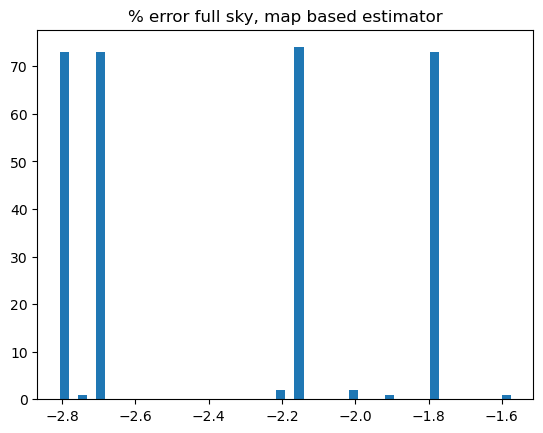

Median of full sky percent error: -99.99845093337608
Mean of full sky percent error: -99.99845088083501
Std dev of full sky percent error: 2.83589315833101e-06


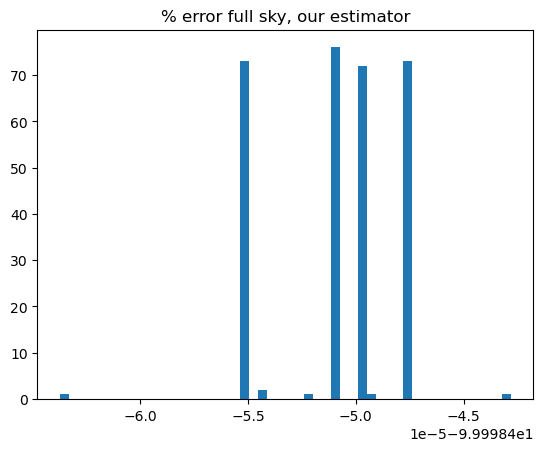

Median of full sky percent error EB estimator: -0.45845767351115896
Mean of full sky percent error EB estimator: -0.4534618994119304
Std dev of full sky percent error EB estimator: 0.11220418681467315


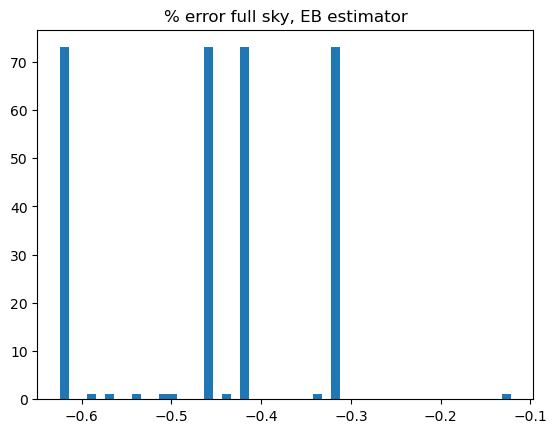

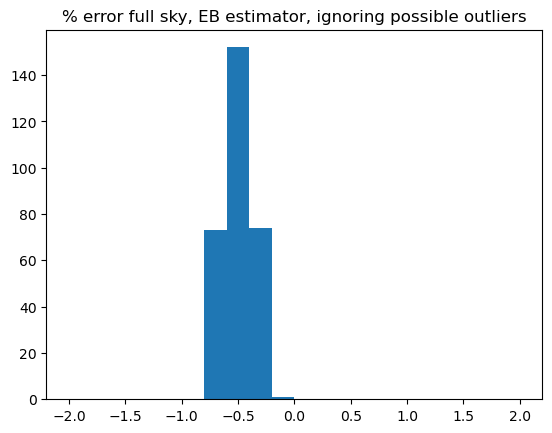

Median of full sky angles Unrot EB estimator: 0.00021688542556177887
Mean of full sky angles Unrot EB estimator: 5.874389197618693e-05
Std dev of full sky angles Unrot EB estimator: 0.0009762400899147656


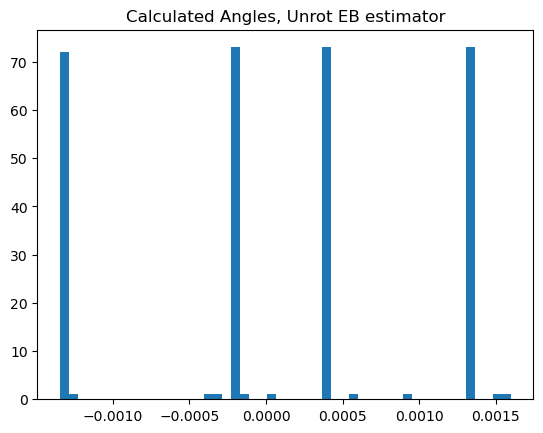

Median of full sky mean TT ratio: 0.9997754308205771
Mean of full sky mean TT ratio: 0.9995913151610788
Std dev of full sky mean TT ratio: 0.0012934701434788522


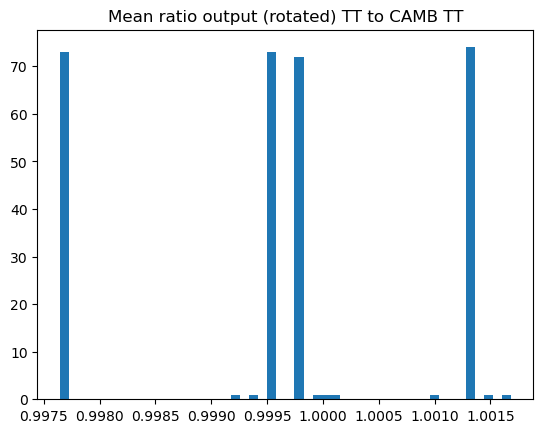

In [35]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [12]:
eb_likelihood_denominators = np.array(eb_likelihood_denominators)

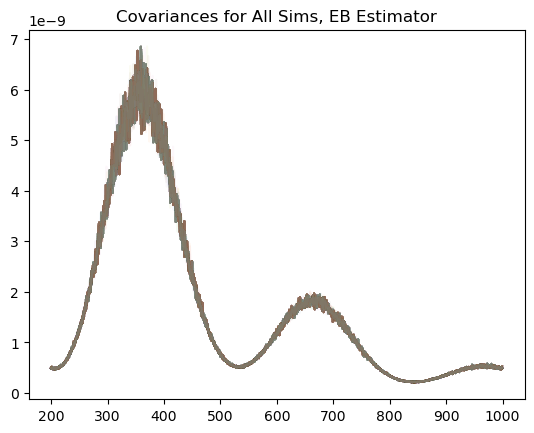

In [21]:
for i in range(eb_likelihood_denominators.shape[0]):
    plt.plot(ell_hp,eb_likelihood_denominators[i],alpha=0.05)
plt.title('Covariances for All Sims, EB Estimator')
plt.show()
plt.close()

In [23]:
eb_numerators = np.array(eb_numerators)

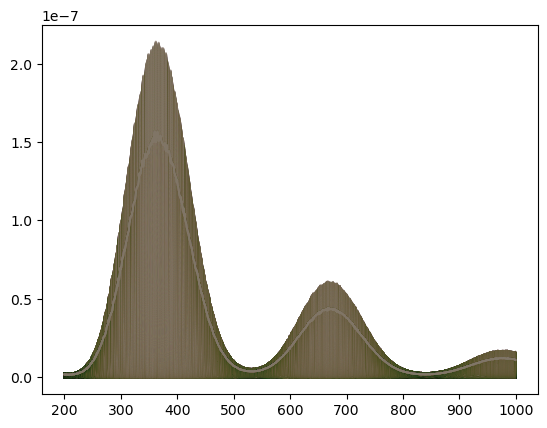

In [33]:
# This is just for the last sim, but it is the numerator calculated for all 20000 points at which
# the likelihood was sampled
for i in range(eb_numerators.shape[0]):
    plt.plot(ell_hp,eb_numerators[i],alpha=0.05)
plt.show()
plt.close()

In [38]:
def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb) # Testing without EB - all of the denominator will come from CAMB in this test
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood, numerator, denominator

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)

    bin_sampled_likelihood = []
    numerators = []
    
    for angle in angles_rad:
        likelihood, numerator, denominator = null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)
        numerators.append(numerator)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values, numerators, denominator

In [39]:
# Doing 300 sims of full sky maps plus noise with an ell range of 200-1000 and a rot angle of 1 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Doing the rotation in PS space instead of map space

# Testing getting rid of EB term in EB covariance so that the covariance only comes from CAMB
# Again passing the full covariance in for our estimator
# Also (clunkily) saving the numerators and denominators of the likelihoods so I can anaylze them more closely
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []
likelihood_numerators = []
likelihood_denominators = []
eb_likelihood_numerators = []
eb_likelihood_denominators = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = np.random.randint(0,100)
    np.random.seed(SEEDVALUE)
    # Trying to make the reference map without noise to see if that affects things
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at random angles to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding them together
    unrot_sim_maps = unrot_sim_maps + noise_maps
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Passing covariance of 1.0 for our estimator
    fit_values,numerators,denominator = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #likelihood_numerators.append(numerators)
    likelihood_denominators.append(denominator)
    # Passing CAMB values for EE and BB in covariance
    null_eb_fit_values,eb_numerators,eb_denominator  = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE[min_ell:max_ell],ClBB[min_ell:max_ell],ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #eb_likelihood_numerators.append(eb_numerators)
    eb_likelihood_denominators.append(eb_denominator)
    unrot_null_eb_fit_values,_,_ = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:10:33<00:00, 14.11s/it]


Median of full sky percent error, map based estimator: -2.130393729762403
Mean of full sky percent error, map based estimator: -2.1710988744273236
Std dev of full sky percent error, map based estimator: 0.13890780202583114


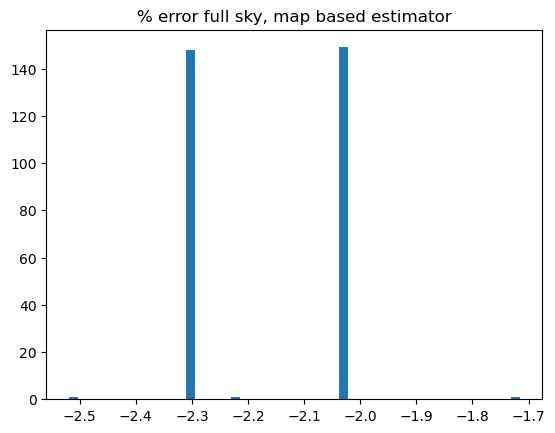

Median of full sky percent error: -1.0491367481577973
Mean of full sky percent error: -1.0659339729019288
Std dev of full sky percent error: 0.038190071813426256


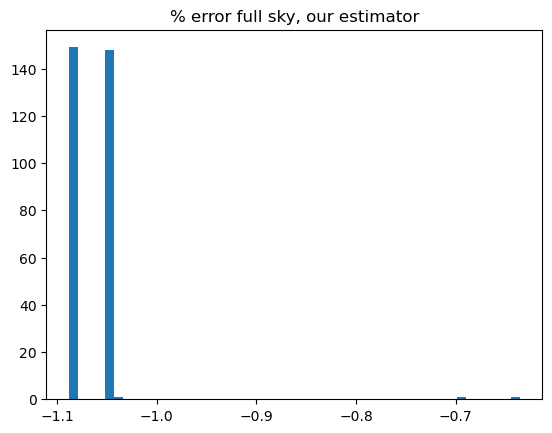

Median of full sky percent error EB estimator: -0.4719747988720935
Mean of full sky percent error EB estimator: -0.5029708075648404
Std dev of full sky percent error EB estimator: 0.12353571613874952


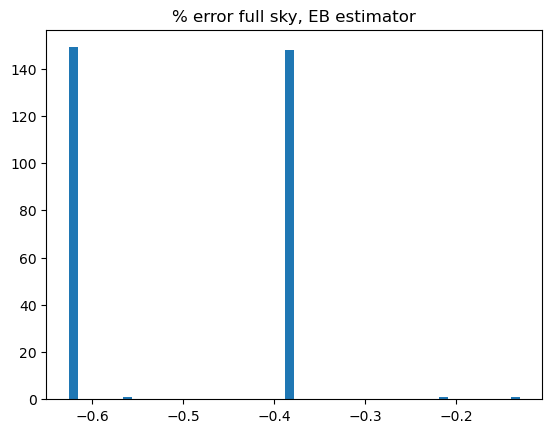

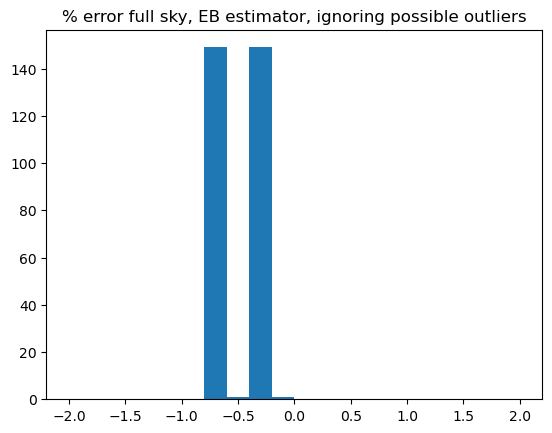

Median of full sky angles Unrot EB estimator: -0.0007016942747022587
Mean of full sky angles Unrot EB estimator: -0.0013246297059753716
Std dev of full sky angles Unrot EB estimator: 0.0006403882466168634


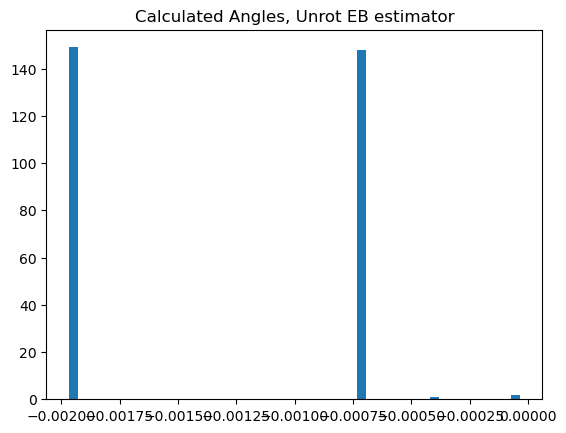

Median of full sky mean TT ratio: 0.9989092463528871
Mean of full sky mean TT ratio: 0.9977121463780323
Std dev of full sky mean TT ratio: 0.0012914685366671428


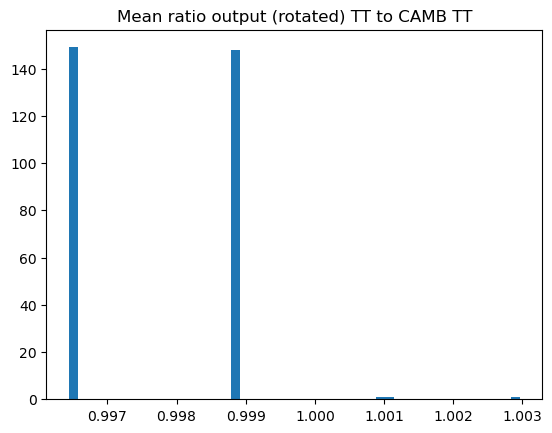

In [40]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

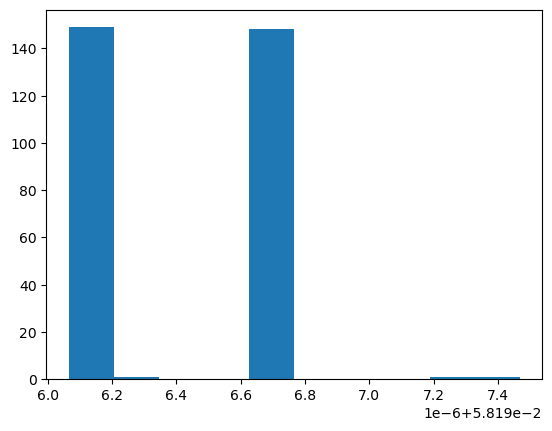

In [43]:
# This is the distribution of errorbars on the recovered EB angles from the last run
# They seem to be basically the same, which is consistent with the idea that the covariance is effectively the 
# same for all of these sims.
eb_errorbars = np.array(output_null_eb_angles)[:,1]

plt.hist(eb_errorbars)
plt.show()
plt.close()

In [45]:
# Doing 300 sims of full sky maps plus noise with an ell range of 200-1000 and a rot angle of 1 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Doing the rotation in PS space instead of map space

# Passing CAMB values for covariance but unrot EE for numerator in EB estimator
# Also (clunkily) saving the numerators and denominators of the likelihoods so I can anaylze them more closely
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []
likelihood_numerators = []
likelihood_denominators = []
eb_likelihood_numerators = []
eb_likelihood_denominators = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = np.random.randint(0,100)
    np.random.seed(SEEDVALUE)
    # Trying to make the reference map without noise to see if that affects things
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at random angles to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding them together
    unrot_sim_maps = unrot_sim_maps + noise_maps
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values,numerators,denominator = sample_likelihood_and_fit(estimator,covariance,ClEE_unrot,\
                                           angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #likelihood_numerators.append(numerators)
    likelihood_denominators.append(denominator)
    # Passing CAMB values for EE and BB in covariance
    # Also trying the unrotated EE for the comparison in the numerator
    null_eb_fit_values,eb_numerators,eb_denominator = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE[min_ell:max_ell],ClBB[min_ell:max_ell],ClEE_unrot,\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #eb_likelihood_numerators.append(eb_numerators)
    eb_likelihood_denominators.append(eb_denominator)
    unrot_null_eb_fit_values,_,_ = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE_unrot,\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:11:06<00:00, 14.22s/it]


Median of full sky percent error, map based estimator: -2.171736248503292
Mean of full sky percent error, map based estimator: -2.1717362485032923
Std dev of full sky percent error, map based estimator: 0.1355516353195585


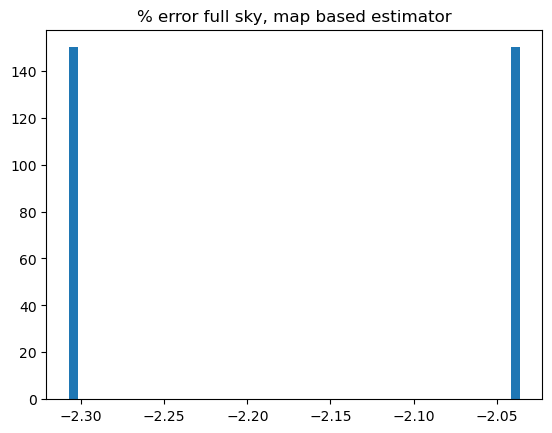

Median of full sky percent error: -0.4738759029859485
Mean of full sky percent error: -0.4738759029859485
Std dev of full sky percent error: 3.3581909003599364e-05


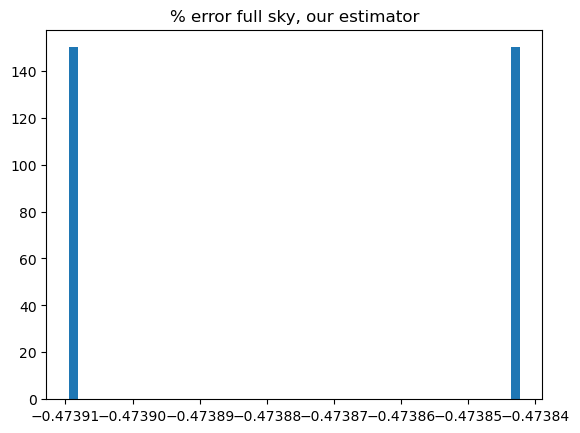

Median of full sky percent error EB estimator: -0.6271746219654761
Mean of full sky percent error EB estimator: -0.6271746219654761
Std dev of full sky percent error EB estimator: 0.05400559616700607


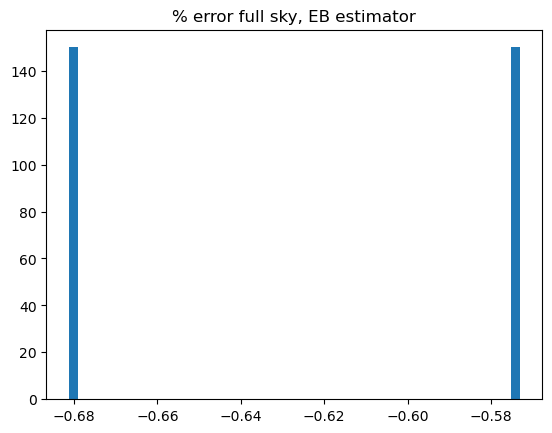

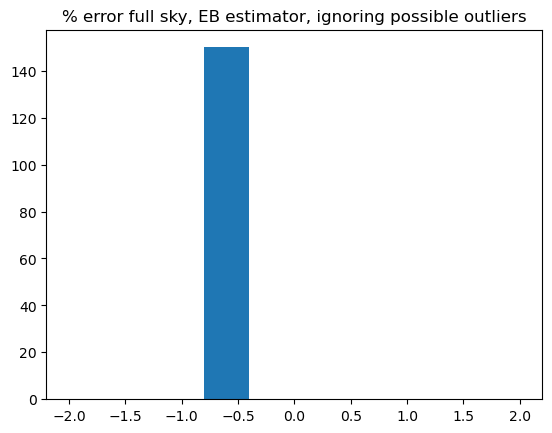

Median of full sky angles Unrot EB estimator: -0.0012114384407648105
Mean of full sky angles Unrot EB estimator: -0.0012114384407648107
Std dev of full sky angles Unrot EB estimator: 0.0006708830807942951


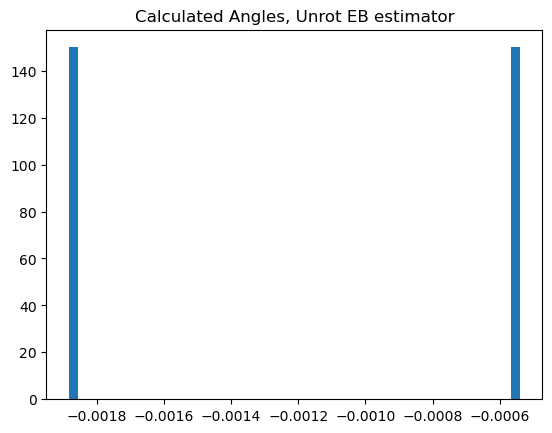

Median of full sky mean TT ratio: 0.9976767179237933
Mean of full sky mean TT ratio: 0.9976767179237932
Std dev of full sky mean TT ratio: 0.0012325284290938265


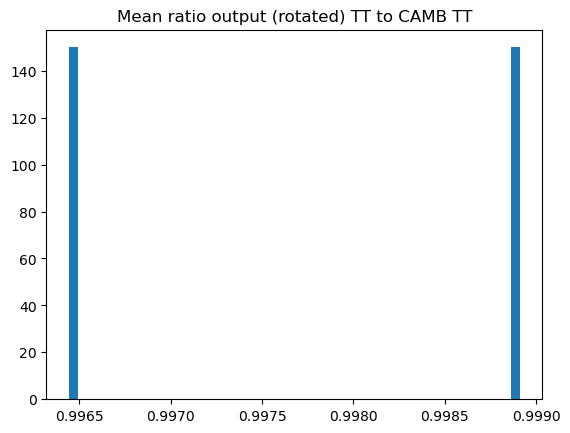

In [46]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [47]:
# Doing 300 sims of full sky maps plus noise with an ell range of 200-1000 and a rot angle of 1 deg
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Doing the rotation in PS space instead of map space

# Passing rot anafast values for covariance and unrot EE for numerator in EB estimator
# Also (clunkily) saving the numerators and denominators of the likelihoods so I can anaylze them more closely
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []
likelihood_numerators = []
likelihood_denominators = []
eb_likelihood_numerators = []
eb_likelihood_denominators = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = np.random.randint(0,100)
    np.random.seed(SEEDVALUE)
    # Trying to make the reference map without noise to see if that affects things
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at random angles to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding them together
    unrot_sim_maps = unrot_sim_maps + noise_maps
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values,numerators,denominator = sample_likelihood_and_fit(estimator,covariance,ClEE_unrot,\
                                           angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #likelihood_numerators.append(numerators)
    likelihood_denominators.append(denominator)
    # Passing rotated anafast values for EE and BB in covariance
    # Also trying the unrotated EE for the comparison in the numerator
    null_eb_fit_values,eb_numerators,eb_denominator = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE_unrot,\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #eb_likelihood_numerators.append(eb_numerators)
    eb_likelihood_denominators.append(eb_denominator)
    unrot_null_eb_fit_values,_,_ = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE_unrot,\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:11:26<00:00, 14.29s/it]


Median of full sky percent error, map based estimator: -2.171736248503292
Mean of full sky percent error, map based estimator: -2.1717362485032923
Std dev of full sky percent error, map based estimator: 0.1355516353195585


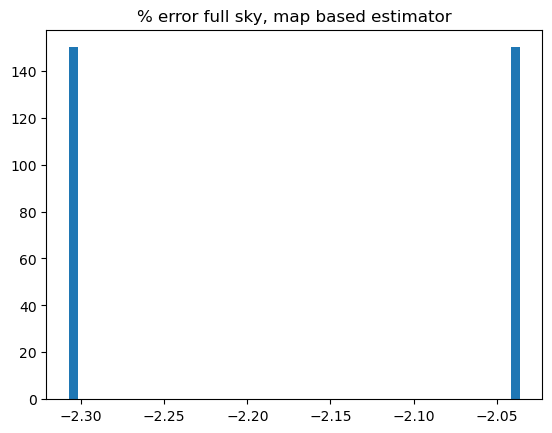

Median of full sky percent error: -0.4738759029859485
Mean of full sky percent error: -0.4738759029859485
Std dev of full sky percent error: 3.3581909003599364e-05


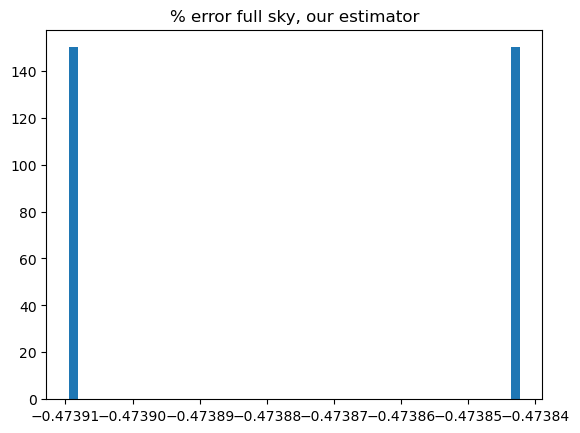

Median of full sky percent error EB estimator: -0.7461546799623298
Mean of full sky percent error EB estimator: -0.7461546799623296
Std dev of full sky percent error EB estimator: 0.040248745112858586


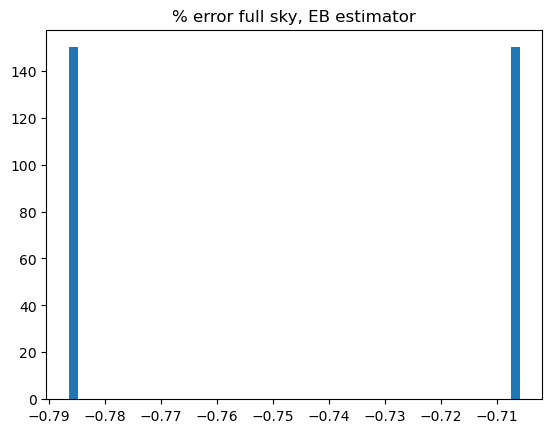

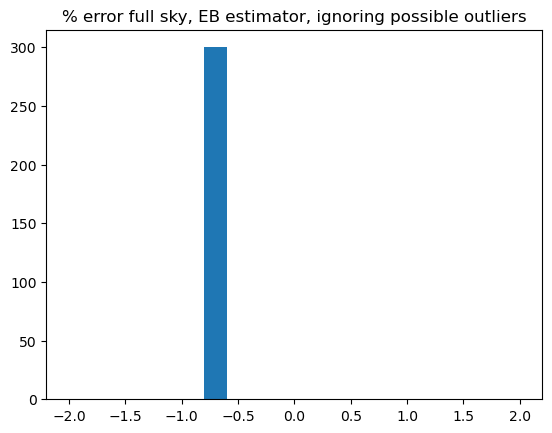

Median of full sky angles Unrot EB estimator: -0.0012114384407648105
Mean of full sky angles Unrot EB estimator: -0.0012114384407648107
Std dev of full sky angles Unrot EB estimator: 0.0006708830807942951


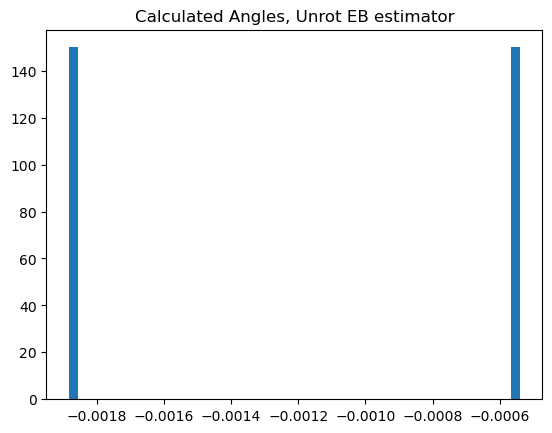

Median of full sky mean TT ratio: 0.9976767179237933
Mean of full sky mean TT ratio: 0.9976767179237932
Std dev of full sky mean TT ratio: 0.0012325284290938265


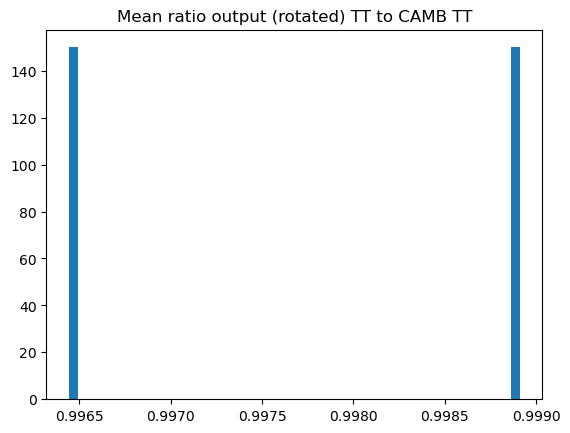

In [48]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

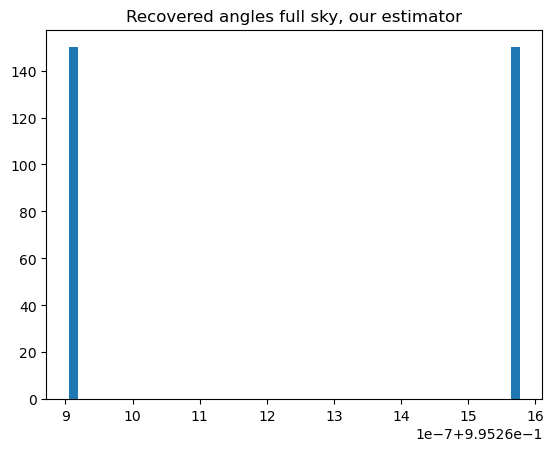

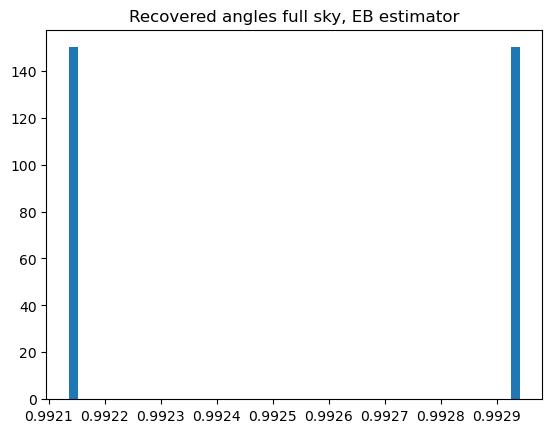

In [49]:
# Plotting the angles by themselves instead of percent difference
plt.hist(output_angles_only,bins=50)
plt.title("Recovered angles full sky, our estimator")
plt.show()
plt.close()
plt.hist(output_null_eb_angles_only,bins=50)
plt.title("Recovered angles full sky, EB estimator")
plt.show()
plt.close()